# Notes on Computing the Rollout Acquisition Function
## Considerations
- Using expected improvement as a control variate doesn't behave as anticipated. You can inspect the difference between acquisitions evaluated with or without this control variate by setting the named argument in, simulate_trajectory, variance_reduction to false or true, i.e.: `simulate_trajectory(..., variance_reduction=true)`. The logic for implementing the EI control variate is located at `src/rollout.jl`.

In [11]:
using Distributions
using LinearAlgebra
using Plots

All the necessary imports for our computations of interest

In [12]:
include("../testfns.jl")
include("../rollout.jl")
include("../utils.jl")

to (generic function with 1 method)

## Basic Setup

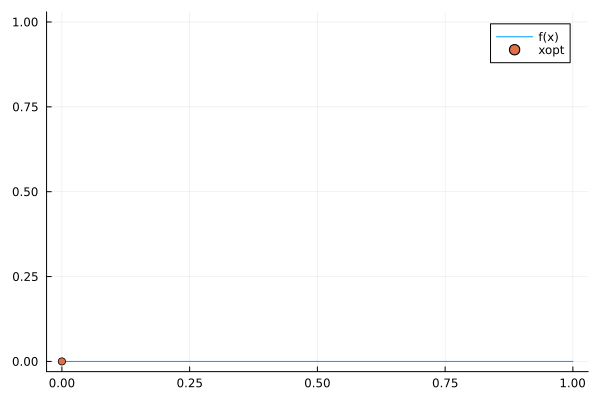

In [13]:
# Visualize 1D test function
# testfn = apply_scale(TestLinearCosine1D(1., 9.2), 1.)
# testfn = TestQuadratic1D()
testfn = TestConstant(lbs=[0.], ubs=[1.])
tplot(testfn)

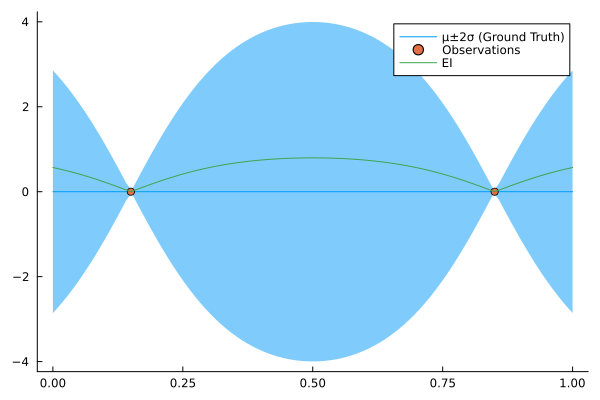

In [14]:
MC_SAMPLES = 2000
NUMBER_OF_STARTS = 8
HORIZON = 1
USE_LDS = true
INITIAL_SAMPLES = 2

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
# ψ = kernel_matern52(θ)
ψ = kernel_scale(kernel_matern52, [5., .25])

lbs, ubs = testfn.bounds[:, 1], testfn.bounds[:, 2]
domain = first(lbs):.01:first(ubs)

# Generate low discrepancy sequence and standard pseudo-random sequence
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, 1, HORIZON + 1)
rns = randn(MC_SAMPLES, 1, HORIZON+1);
lds_rns_d = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON + 1)
rns_d = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1)

# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    initial_guesses[:, 1], # Will be overriden later
    HORIZON,
    MC_SAMPLES,
    USE_LDS ? lds_rns : rns,
    lbs,
    ubs,
)
tp_fm = TrajectoryParameters(
    initial_guesses[:, 1], # Will be overriden later
    HORIZON,
    MC_SAMPLES,
    USE_LDS ? lds_rns_d : rns_d,
    lbs,
    ubs,
)

# Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
Xinit = [.15;; .85;;]
yinit = testfn.f.(eachcol(Xinit))

# Fit surrogate with hyperparameters learned via MLE
sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
plot1D(sur, xmin=first(lbs), xmax=first(ubs))
EIb = [sur([x]).EI for x in domain]
plot!(domain, EIb, label="EI")

## On Perturbing the jth Policy Solve

Given some policy solve $r_j$, we have the following dependence structure on previous observations:

$$
\newcommand{\bfx}{\mathbf{x}}
\newcommand{\bfr}{\mathbf{r}}
\bfr_j(\bfx_j; \bfx_0, y_0, \ldots, \bfx_{j-1}, y_{j-1}) = 0
$$

In [15]:
h = 1
sfsur = fit_sfsurrogate(sur, h)
fsur = fit_fsurrogate(sur, h-1)

xnew = vec(randsample(1, testfn.dim, lbs, ubs))
update_sfsurrogate!(sfsur, xnew, testfn(xnew))
update_fsurrogate!(fsur, xnew, testfn(xnew))
xnew = vec(randsample(1, testfn.dim, lbs, ubs))
# update_sfsurrogate!(sfsur, xnew, testfn(xnew))
# update_fsurrogate!(fsur, xnew, testfn(xnew))

dp_sur, sp_sur  = fit_perturbation_surrogates(sfsur, h-1)
sfsx = sfsur(xnew, fantasy_index=h-1)
fsx = fsur(xnew)

δx = rand(1)
sp_sx = eval(sp_sur, sfsx, δx=δx, current_step=h-1)
dp_sx = eval(dp_sur, sfsx, δx=δx, current_step=h-1);


δX = zeros(testfn.dim, INITIAL_SAMPLES + h)
δX[:, INITIAL_SAMPLES+h] .= δx
∇ys = [zeros(testfn.dim) for _ in 1:INITIAL_SAMPLES + h]
# ∇ys[end] = testfn.∇f(xnew)
∇ys[end] = fsx.∇μ
δsur = fit_δsurrogate(fsur, δX, ∇ys);
δsx = δsur(fsx);

In [16]:
println("Relative Error δμ: $(norm(δsx.μ - (sp_sx.μ + dp_sx.μ)) / norm(δsx.μ))")
println("Relative Error δ∇μ: $(norm(δsx.∇μ - (sp_sx.∇μ + dp_sx.∇μ)) / norm(δsx.∇μ))")

println("Relative Error δσ: $(norm(δsx.σ - (sp_sx.σ + dp_sx.σ)) / norm(δsx.σ))")
println("Relative Error δ∇σ: $(norm(δsx.∇σ - (sp_sx.∇σ + dp_sx.∇σ)) / norm(δsx.∇σ))")

println("Relative Error δz: $(norm(δsx.z - (sp_sx.z + dp_sx.z)) / norm(δsx.z))")
println("Relative Error δ∇z: $(norm(δsx.∇z - (sp_sx.∇z + dp_sx.∇z)) / norm(δsx.∇z))")

println("Relative Error δEI: $(norm(δsx.EI - (sp_sx.EI + dp_sx.EI)) / norm(δsx.EI))")
println("Relative Error δ∇EI: $(norm(δsx.∇EI - (sp_sx.∇EI + dp_sx.∇EI)) / norm(δsx.∇EI))")

Relative Error δμ: NaN
Relative Error δ∇μ: NaN
Relative Error δσ: 0.0
Relative Error δ∇σ: 0.0
Relative Error δz: NaN
Relative Error δ∇z: NaN
Relative Error δEI: 0.0
Relative Error δ∇EI: 0.0


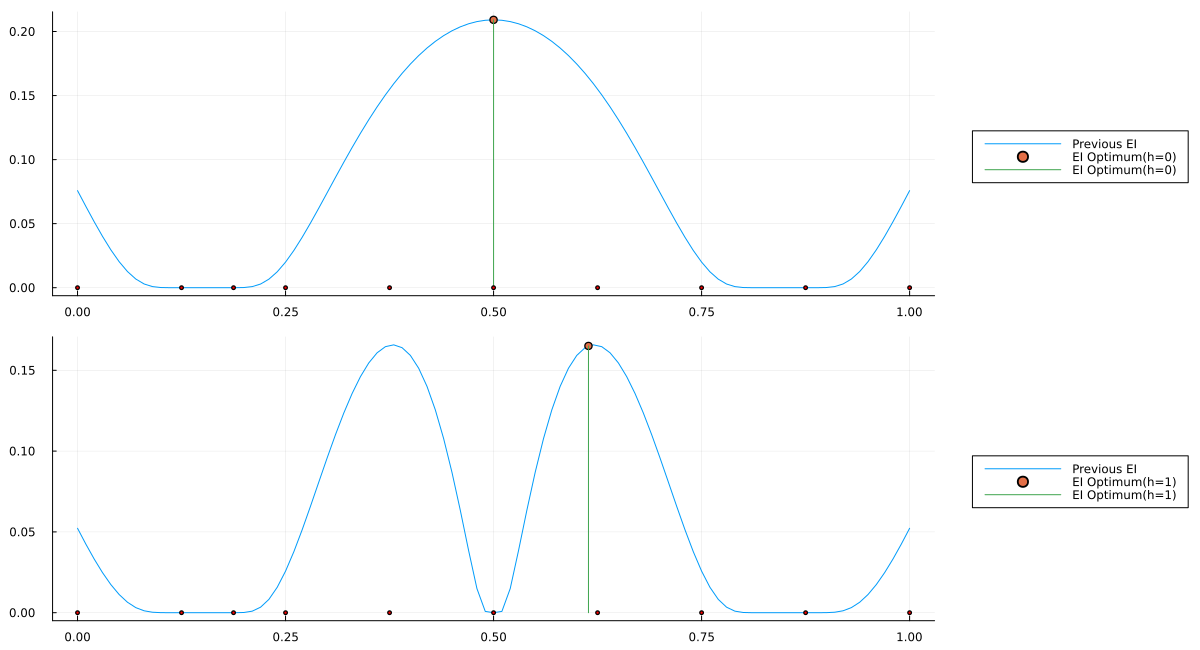

In [17]:
domain = first(lbs):.01:first(ubs)

# Create the trajectory
AT = AdjointTrajectory(sur, tp.x0, tp.h)
stochastic_sampler = StochasticObservable(AT.fs, lds_rns_d[1, :, :], HORIZON + 1)
# deterministic_sampler = DeterministicObservable(testfn, HORIZON + 1)

# Adjoint Rollout
adjoint_rollout!(AT, tp.lbs, tp.ubs, xstarts=initial_guesses, get_observation=stochastic_sampler)
# adjoint_rollout!(AT, tp.lbs, tp.ubs, xstarts=initial_guesses, get_observation=deterministic_sampler)

all_plots = []
for upto_index in 0:HORIZON
    EIx = zeros(length(domain))
    for (i, xx) in enumerate(domain)
        EIx[i] = AT.fs([xx], fantasy_index=upto_index-1).EI
    end
    p = plot(domain, EIx, label="Previous EI")
    target_location = first(AT.fs.X[:, INITIAL_SAMPLES + upto_index + 1])
    scatter!([target_location], [AT.fs([target_location], fantasy_index=upto_index-1).EI], label="EI Optimum(h=$upto_index)")
    plot!([target_location, target_location], [0., AT.fs([target_location], fantasy_index=upto_index-1).EI], label="EI Optimum(h=$upto_index)")
    scatter!(p, initial_guesses, zeros(NUMBER_OF_STARTS), color=:red, label=nothing, markersize=2)
    push!(all_plots, p)
end

plot(all_plots..., layout=(length(all_plots), 1), size=(1200, 325 * (HORIZON + 1)), legend=:outerright)

## Question
We have dry_dyj as the perturbation of our policy solve wrt to yj. I'm mixed up on the dimensionality of our object here. I think ybar should be a vector.

In [ ]:
resolutions = zeros(MC_SAMPLES)
gresolutions = zeros(testfn.dim, MC_SAMPLES)

dense_acquisition = zeros(length(domain))
dense_forward_acquisition = zeros(length(domain))
dense_gradient_acquisition = zeros(testfn.dim, length(domain))
dense_forward_gradient_acquisition = zeros(testfn.dim, length(domain))
fd_gradient_acquisition = zeros(testfn.dim, length(domain))
dense_std = zeros(length(domain))
h = 1e-6

for (index, xx) in enumerate(domain)
    print("|")
    tp.x0 = [xx]
    tp_fm.x0 = [xx]
    # Adjoint mode
    dense_acquisition[index], dense_std[index], dense_gradient_acquisition[:, index] = simulate_adjoint_trajectory(
        sur, tp_fm, initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions
    )
    # dense_acquisition[index], dense_std[index], dense_gradient_acquisition[:, index] = deterministic_simulate_trajectory(
    #     sur, tp, initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions, testfn=testfn
    # )

    # Finite difference mode
    # tp_fm.x0 = [xx - h]
    # tp.x0 = [xx - h]
    # aminus, _, _ = simulate_adjoint_trajectory(
    #     sur, tp_fm, initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions
    # )
    # aminus, _, _ = deterministic_simulate_trajectory(
    #     sur, tp, initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions, testfn=testfn
    # )

    # tp_fm.x0 = [xx + h]
    # tp.x0 = [xx + h]
    # aplus, _, _ = simulate_adjoint_trajectory(
    #     sur, tp_fm, initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions
    # )
    # aplus, _, _ = deterministic_simulate_trajectory(
    #     sur, tp, initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions, testfn=testfn
    # )
    # fd_gradient_acquisition[:, index] .= (aplus - aminus) / 2h

    # Forward mode
    tp.x0 = [xx]
    tp_fm.x0 = [xx]
    dense_forward_acquisition[index], _, dense_forward_gradient_acquisition[:, index] = simulate_trajectory(
        sur, tp_fm, initial_guesses, αxs=resolutions, ∇αxs=gresolutions
    )
end

||||||||||||||||

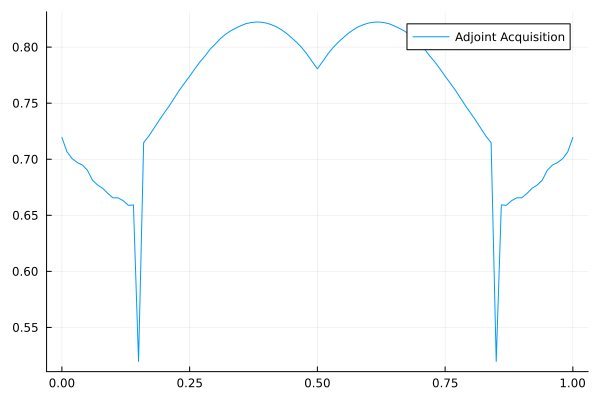

In [9]:
# plot(domain, stdize(dense_acquisition), ribbons=dense_std ./ sqrt(MC_SAMPLES), label="α(h=$HORIZON)")
slice = 1:length(domain)
plot(domain[slice], dense_acquisition[slice], label="Adjoint Acquisition")
# zeros_indices = find_zeros(dense_gradient_acquisition[1, slice])
# scatter!(domain[zeros_indices], dense_acquisition[zeros_indices])
# plot!(domain[slice], dense_forward_acquisition[slice], label="MOGP Acquisition")

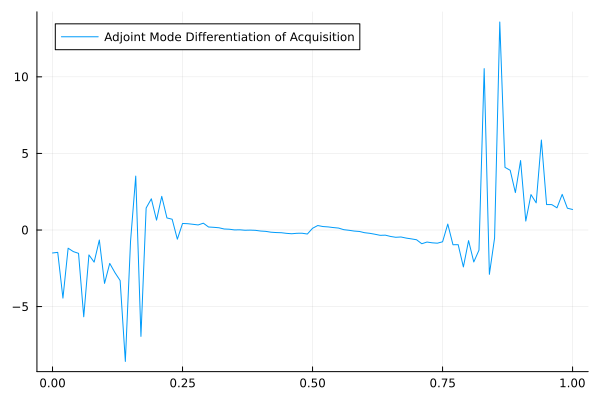

In [10]:
# plot(domain[slice], fd_gradient_acquisition[1, slice], label="Finite Difference of Acquisition")
plot(domain[slice], dense_gradient_acquisition[1, slice], label="Adjoint Mode Differentiation of Acquisition")
# plot!(domain[slice], dense_forward_gradient_acquisition[1, slice], label="forward dα(h=$HORIZON)")

## Sampling from Gaussian Process Posteriors

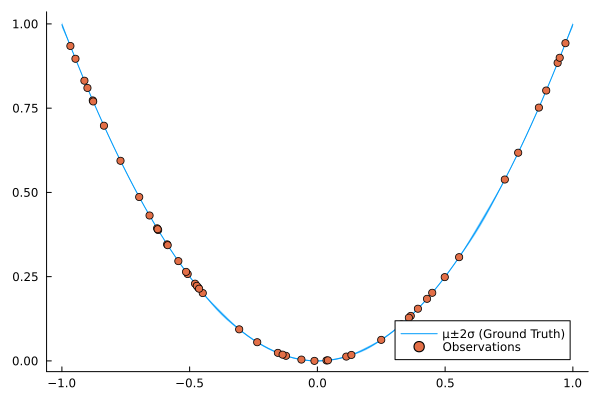

In [12]:
MC_SAMPLES = 10
NUMBER_OF_STARTS = 16
HORIZON = 1
USE_LDS = true
INITIAL_SAMPLES = 50

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
ψ = kernel_matern52(θ)
# ψ = kernel_scale(kernel_matern52, [5., .25])

lbs, ubs = testfn.bounds[:, 1], testfn.bounds[:, 2]
domain = first(lbs):.01:first(ubs)
Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
yinit = testfn.f.(eachcol(Xinit))

# Fit surrogate with hyperparameters learned via MLE
sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
plot1D(sur, xmin=first(lbs), xmax=first(ubs))

Depending on whether or not we want gradient draws from our Gaussian Process affects how we compute the cross-covariances and variance of the current location.

In [13]:
observation = zeros(testfn.dim + 1, length(domain)) 
stdnormal = randn(testfn.dim + 1)

for (index, xi) in enumerate(domain)
    observation[:, index] = gp_draw(sur, [xi], stdnormal=stdnormal, with_gradient=true)
end

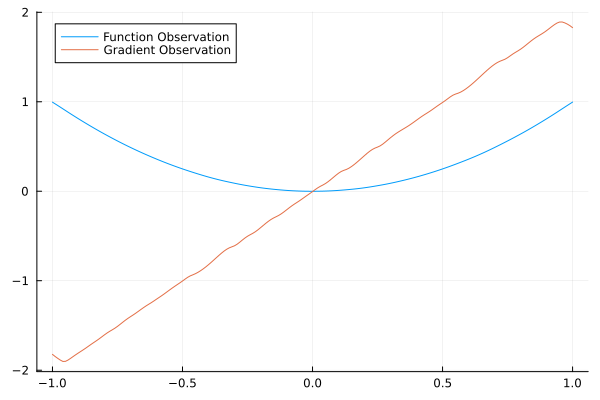

In [14]:
plot(domain, observation[1, :], label="Function Observation")
plot!(domain, observation[2, :], label="Gradient Observation")

In [63]:
T = AdjointTrajectory(sur, tp.x0, tp.h)
sampler = StochasticObservable(T.fs, tp_fm.rnstream_sequence[1, :, :], tp.h + 1)
attach_observable!(T, sampler)
adjoint_rollout!(T, tp.lbs, tp.ubs;
    get_observation=T.observable,
    xstarts=initial_guesses,
)

In [65]:
T.observable.observations

1-element Vector{Float64}:
 0.10023282816130596

In [31]:
gradient(t::TestFunction) = testfn.∇f

gradient (generic function with 2 methods)

In [32]:
gradient(testfn)([2.])

1-element Vector{Float64}:
 4.0

In [34]:
testfn([2.])

4.0